# Installing & Importing Libraries

In [3]:
!pip install pyitlib
!pip install mido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyitlib: filename=pyitlib-0.2.2-py3-none-any.whl size=28501 sha256=c5b1bde1d7067b3a359cd3a7f8b0994f762aa3c0748e9e05540715c95a0fd796
  Stored in directory: /root/.cache/pip/wheels/ea/1d/5e/a1ed049f60c80286f937f1ab1d3574b49d79afc93d51247104
Successfully built pyitlib
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import math
from collections import Counter
import mido
import string
from pyitlib import discrete_random_variable as drv
import music21

# Basic Shannon Entropy Functions

## Shannon Entropy from scratch

In [5]:
def pmf(arr):
  # Use the Counter method to count the frequency of each element
  element_freq = Counter(arr)

  # Calculate the probability mass function
  pmf = {}
  for elem, freq in element_freq.items():
    pmf[elem] = freq / len(arr)

  return pmf

In [6]:
def dict_vals_to_array(dictionary):
  # Initialize an empty NumPy array
  arr = np.array([])

  # Iterate over the values in the dictionary
  for value in dictionary.values():
    # Append the value to the array
    arr = np.append(arr, value)

  return arr

In [7]:
def shannon_entropy(array_with_probabilities):
  entropies = []
  for key, value in array_with_probabilities.items():
    logged = value * math.log2(value)
    entropies.append(logged)

  source_entropy = - sum(entropies)
  return source_entropy

## Using PyItlib

In [8]:
def extract_notes(midi_file):
  # Load the MIDI file into a music21 stream
  stream = music21.converter.parse(midi_file)

  # Extract the notes and chords from the stream
  notes = []
  for element in stream.recurse():
    # If the element is a note or a chord, add it to the list
    if isinstance(element, music21.note.Note):
      # Extract the pitch and rhythm information for the note
      pitch = str(element.pitch)
      rhythm = element.duration.type
      notes.append(pitch + '_' + str(rhythm))
    elif isinstance(element, music21.chord.Chord):
      # Extract the pitch and rhythm information for the chord
      pitches = '.'.join(str(n) for n in element.normalOrder)
      rhythm = element.duration.type
      notes.append(pitches + '_' + str(rhythm))

  return notes

In [9]:
def entropy_pipeline(filename):
  piece_notes = extract_notes(filename)
  piece_probs = dict_vals_to_array(pmf(piece_notes))
  entropyOfPiece = drv.entropy_pmf(piece_probs)

  return entropyOfPiece

In [10]:
def generate_conditional_probability_matrix(seq):
  # Create a dictionary to store the frequency of each element
  element_freq = {}
  for i in range(len(seq) - 1):
    current_elem = seq[i]
    next_elem = seq[i + 1]
    if current_elem in element_freq:
      if next_elem in element_freq[current_elem]:
        element_freq[current_elem][next_elem] += 1
      else:
        element_freq[current_elem][next_elem] = 1
    else:
      element_freq[current_elem] = {next_elem: 1}

  # Calculate the conditional probability matrix
  elements = list(element_freq.keys())
  num_elements = len(elements)
  matrix = np.zeros((num_elements, num_elements))
  for i, current_elem in enumerate(elements):
    total_count = sum(element_freq[current_elem].values())
    for j, next_elem in enumerate(elements):
      count = element_freq[current_elem].get(next_elem, 0)
      matrix[i, j] = count / total_count

  return matrix

In [11]:
### This is a function developed as an alternative to the pyitlib conditional 
### entropy ###

def calculate_conditional_entropy(matrix):
  # Check that the matrix is a square matrix
  num_rows, num_cols = matrix.shape
  if num_rows != num_cols:
    raise ValueError('Matrix must be square')

  # Calculate the conditional entropy
  entropy = 0
  for i in range(num_rows):
    for j in range(num_cols):
      probability = matrix[i, j]
      if probability > 0:
        entropy -= probability * np.log2(probability)

  return entropy

In [12]:
def conditional_entropy_pipeline(filename):

  #Generate conditional probability matrix X, Y
  piece_notes = extract_notes(filename)
  piece_probs = dict_vals_to_array(pmf(piece_notes))
  cond_prob_matrix = generate_conditional_probability_matrix(piece_probs)
  print(cond_prob_matrix.shape)

  # This function now uses the library method not the one developed above
  conditionalEntropyOfPiece = drv.entropy_conditional(cond_prob_matrix, cartesian_product=True)

  return conditionalEntropyOfPiece

# Calculating Shannon Entropy over Notes

## Baroque Classical

In [93]:
bach_847_shentropy = entropy_pipeline('bach_847.mid')
print(bach_847_shentropy)

5.506950023584544


In [94]:
bach_goldberg1_shentropy = entropy_pipeline('goldberg_variation1.mid')
print(bach_goldberg1_shentropy)

5.620435538632966


In [95]:
haydn_sonata50_shentropy = entropy_pipeline('haydn_sonata50.mid')
print(haydn_sonata50_shentropy)

6.328727299804061


In [96]:
mozart_allaturca_shentropy = entropy_pipeline('mz_331_3.mid')
print(mozart_allaturca_shentropy)

5.998407748300801


In [100]:
baroque_classical_shentropies = {'Bach 847': bach_847_shentropy, 
                                 'Bach Goldberg 1': bach_goldberg1_shentropy,
                                 'Haydn Sonata 50': haydn_sonata50_shentropy, 
                                 'Mozart Alla Turca': mozart_allaturca_shentropy}

In [101]:
import json

with open("barok_shentropy.json", "w") as outfile:
    json.dump(baroque_classical_shentropies, outfile)

## Romantic

In [42]:
chopin_waltzCsharp_shentropy = entropy_pipeline('Waltz-in-C-Sharp-Minor-Opus-64-Nr-2.mid')
print(chopin_waltzCsharp_shentropy)

7.432077849211035


In [43]:
lizst_liebestraum_shentropy = entropy_pipeline('liz_liebestraum.mid')
print(lizst_liebestraum_shentropy)

6.780336426513806


In [45]:
schubert_impromptu2_shentropy = entropy_pipeline('schubert_impromptu2.mid')
print(schubert_impromptu2_shentropy)

6.617533694253459


In [102]:
tchaikovsky_june_shentropy = entropy_pipeline("tchaikovsky_june.mid")
print(tchaikovsky_june_shentropy)

6.733572845656736


In [103]:
romantic_shentropies = {'Chopin Waltz': chopin_waltzCsharp_shentropy,
                        'Lizst Liebestraum': lizst_liebestraum_shentropy,
                        'Schubert Impromptu': schubert_impromptu2_shentropy,
                        'Tchaikovsky June': tchaikovsky_june_shentropy}

In [107]:
with open("/content/romantik_shentropy.json", "w") as outfile1:
    json.dump(romantic_shentropies, outfile1)

## Early-Modern / Late Romantic

In [64]:
scriabin_verslaflamme_shentropy = entropy_pipeline("vers_la_flamme_72_(c)lefeldt.mid")
print(scriabin_verslaflamme_shentropy)

6.808891455845934


In [65]:
debussy_prelude8_shentropy = entropy_pipeline("debussyprelude.mid")
print(debussy_prelude8_shentropy)

6.664076493493506


In [66]:
schoenberg_op11mvt3_shentropy = entropy_pipeline("schoenberg_drei_klavierstucke_11_3_(c)simonetto.mid")
print(schoenberg_op11mvt3_shentropy)

8.058324461758446


In [67]:
bartok_sonata1mvt1_shentropy = entropy_pipeline("bartok_piano_sonata_1_cunknown.mid")
print(bartok_sonata1mvt1_shentropy)

7.298191604966489


In [69]:
earlymodern_shentropies = {'Scriabin Vers La Flamme': scriabin_verslaflamme_shentropy,
                           'Debussy Prelude 8:' : debussy_prelude8_shentropy,
                           'Schoenberg op11mvt3': schoenberg_op11mvt3_shentropy,
                           'Bartok Sonata 1 Mvt1': bartok_sonata1mvt1_shentropy}

In [108]:
with open("/content/earlymodern_shentropy.json", "w") as outfile1:
    json.dump(earlymodern_shentropies, outfile1)

## Contemporary

In [70]:
messiaen_lesanges_shentropy = entropy_pipeline("messiaen_la_nativite_du_seigneur_6_(c)mccoy.mid")
print(messiaen_lesanges_shentropy)

6.46667916289563


In [79]:
boulez_premieresonata_shentropy = entropy_pipeline("BoulezPREMIERE_SONATE1946.mid")
print(boulez_premieresonata_shentropy)

7.684505477412431


In [83]:
ligeti_disordre_shentropy = entropy_pipeline("tude_1_Dsordre__Gyrgy_Ligeti_with_annotationcolor_coding.mid")
print(ligeti_disordre_shentropy)

6.627844023808542


In [85]:
xenakis_evryali_shentropy = entropy_pipeline('evryalixx.mid')
print(xenakis_evryali_shentropy)

9.954933266409508


In [109]:
contemporary_shentropies = {'Messiaen Les Anges': messiaen_lesanges_shentropy,
                            'Boulez Premier Sonata': boulez_premieresonata_shentropy,
                            'Xenakis Evryali': xenakis_evryali_shentropy,
                            'Ligeti Disordre' : ligeti_disordre_shentropy}

In [110]:
with open("/content/contemporary_shentropy.json", "w") as outfile1:
    json.dump(contemporary_shentropies, outfile1)

In [111]:
def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

In [112]:
def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        result[note-21] = velocity if on_ else 0
    return result

In [113]:
def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]
def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result

In [114]:
def mid2arry(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]

In [116]:
mid2arry(bach_847.mid)

NameError: ignored

In [23]:
arrayz= mid2arry(mid)

NameError: ignored

In [22]:
arrayz.shape

NameError: ignored

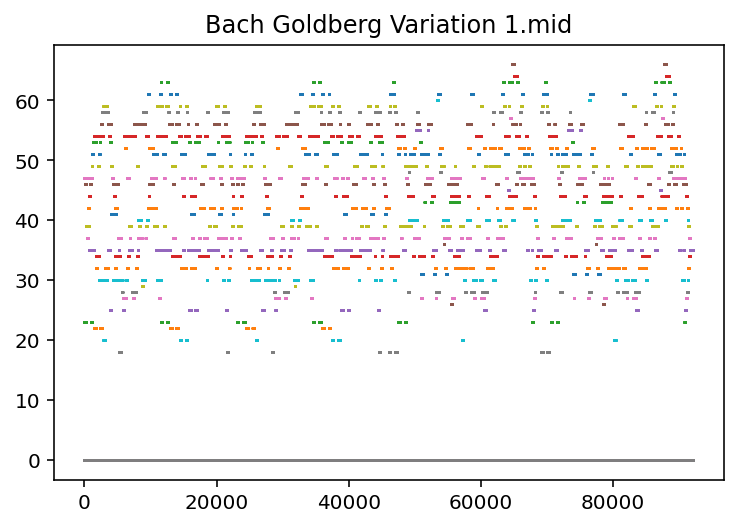

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(arrayz.shape[0]), np.multiply(np.where(arrayz>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("Bach Goldberg Variation 1.mid")
plt.show()
plt.savefig('bach.png', dpi=600)

In [38]:
def detect_midi_type(midi_file):
    mid = mido.MidiFile(midi_file)
    if len(mid.tracks) == 1:
        return "Type 0 (single track)"
    elif all(track[0].time == 0 for track in mid.tracks):
        return "Type 1 (synchronous)"
    else:
        return "Type 2 (asynchronous)"

In [59]:
def track_contents(midi_file):
    mid = mido.MidiFile(midi_file)
    tracks_data = []
    for track_number, track in enumerate(mid.tracks):
        track_type = "music"
        for msg in track:
            if msg.type == 'key_signature' or msg.type == 'time_signature':
                track_type = "metadata"
                break
            elif msg.type == 'note_on':
                track_type = "music"
                break
        tracks_data.append((track_number, track_type))
    return tracks_data

In [60]:
track_contents("bach_847.mid")

[(0, 'metadata'),
 (1, 'music'),
 (2, 'music'),
 (3, 'music'),
 (4, 'music'),
 (5, 'music'),
 (6, 'music'),
 (7, 'music'),
 (8, 'music'),
 (9, 'music')]

In [80]:

def midi_to_matrix(midi_file):
    # Load the MIDI file
    mid = mido.MidiFile(midi_file)

    # Get the resolution (ticks per beat) from the MIDI file
    resolution = mid.ticks_per_beat

    # Get the tempo of the MIDI file
    tempo = mido.bpm2tempo(120)

    # Get the length of the MIDI file in seconds
    midi_length = sum(mido.tick2second(track.length, tempo, resolution) for track in mid.tracks)

    # Create a matrix with 128 rows (for 128 pitches) and 4 * midi_length columns
    matrix = np.zeros((128, int(4 * midi_length)))

    # Initialize a dictionary to store the current notes
    current_notes = {}

    # Iterate through all the tracks in the MIDI file
    for track in mid.tracks:
        # Get the time of the previous event
        prev_time = 0
        # Iterate through all the MIDI events in the track
        for msg in track:
            if msg.time:
                # Calculate the duration of the event in seconds
                duration = mido.tick2second(msg.time, tempo, resolution)
                prev_time += duration
                # Calculate the column index for the note in terms of 1/4 of a second
                column = int(prev_time * 4)
                if msg.type == 'note_on':
                    # Add the note to the current_notes dictionary
                    current_notes[msg.note] = column
                elif msg.type == 'note_off':
                    # If the note is in current_notes, remove it
                    if msg.note in current_notes:
                        del current_notes[msg.note]
                    # Set the corresponding matrix element to 1 for the column and all columns before it
                    for note in current_notes:
                        for i in range(current_notes[note], column):
                            matrix[note][i] = 1

    return matrix

In [88]:

def midi_to_matrix(midi_file):
    # Load the MIDI file
    mid = mido.MidiFile(midi_file)

    # Get the resolution (ticks per beat) from the MIDI file
    resolution = mid.ticks_per_beat

    # Get the tempo of the MIDI file
    tempo = mido.bpm2tempo(120)
    # Initialize the MIDI length to 0
    midi_length = 0
    # Iterate through all the tracks in the MIDI file
    for track in mid.tracks:
        # Iterate through all the MIDI events in the track
        for msg in track:
            if msg.time:
                # Calculate the duration of the event in seconds
                duration = mido.tick2second(msg.time, tempo, resolution)
                # Add the duration to the MIDI length
                midi_length += duration

    # Create a matrix with 128 rows (for 128 pitches) and 4 * midi_length columns
    matrix = np.zeros((128, int(4 * midi_length)))

    # Initialize a dictionary to store the current notes
    current_notes = {}

    # Iterate through all the tracks in the MIDI file
    for track in mid.tracks:
        # Get the time of the previous event
        prev_time = 0
        # Iterate through all the MIDI events in the track
        for msg in track:
            if msg.time:
                # Calculate the duration of the event in seconds
                duration = mido.tick2second(msg.time, tempo, resolution)
                prev_time += duration
                # Calculate the column index for the note in terms of 1/4 of a second
                column = int(prev_time * 4)
                if msg.type == 'note_on':
                    # Add the note to the current_notes dictionary
                    current_notes[msg.note] = column
                elif msg.type == 'note_off':
                    # If the note is in current_notes, remove it
                    if msg.note in current_notes:
                        del current_notes[msg.note]
                    # Set the corresponding matrix element to 1 for the column and all columns before it
                    for note in current_notes:
                        for i in range(current_notes[note], column):
                            matrix[note][i] = 1

    return matrix

In [89]:
bach = midi_to_matrix('bach_847.mid')

array([], shape=(128, 0), dtype=float64)